In [34]:
from functools import partial
import pickle

import tensorflow as tf
from tensorflow.keras.regularizers import l2
import tensorflow.contrib.eager as tfe
from tqdm import tqdm_notebook as tqdm
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
np.set_printoptions(suppress=True)
 
from innlib.models import DeepConditionalModel
from innlib.training import train_online
from innlib.losses import maximum_likelihood_loss
from innlib.viz import plot_true_est_scatter, plot_true_est_posterior_samples, plot_sbc
from innlib.diagnostics import bootstrap_metrics, calibration_error, rmse, R2
import innlib.diagnostics as diag

from it import it_measures

In [9]:
tf.enable_eager_execution()

In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Summary network definition 
<p> The summary network is responsible to learn a fixed size representation of the observed data and extract
    maximally informative statistics from the data. </p>

In [11]:
class RecurrentSummaryNetwork(tf.keras.Model):
    def __init__(self, meta):
        super(RecurrentSummaryNetwork, self).__init__()
        
        
        # This model will then run through the concatenated embeddings
        self.lstm = tf.keras.layers.CuDNNLSTM(meta['n_units'], recurrent_initializer='glorot_uniform')
        self.dense = tf.keras.Sequential([
            tf.keras.layers.Dense(meta['n_units'], activation=meta['activation'])
            for i in range(meta['n_dense'])
        ])
        
        if meta['embedding']:
            self.feature_embedding = [tf.keras.layers.Dense(meta['embedding_dim']) 
                                      for _ in range(meta['embedding_layers'])]
        else:
            self.feature_embedding = None
    
    def call(self, x, training=True):
        """
        Performs a forward pass through the summary network
        Arguments:
        x : tf.Tensor of shape (batch_size, n_obs, x_dim) - a batch of samples from p(x|theta)
        """
        
        if self.feature_embedding is not None:
            x = tf.concat([emb(x) for x, emb in zip(x, self.feature_embedding)], axis=-1)
        
        return self.dense(self.lstm(x))

# Helper functions

## Prior

In [12]:
def prior(batch_size):
    """
    Samples from the prior 'batch_size' times.
    ----------
    
    Arguments:
    batch_size : int -- the number of samples to draw from the prior
    ----------
    
    Output:
    theta : np.ndarray of shape (batch_size, theta_dim) -- the samples batch of parameters
    """
    
    
    epsilons = np.random.uniform(0, 1, size=batch_size)
    xis = np.random.uniform(0, 1, size=batch_size)
    theta = np.c_[epsilons, xis].astype(np.float32)
    return theta

## Forward model

In [13]:
def Likelihood(s,z,vartheta_par):
    if z == 0:
        s = 1-s
    f = s/sum(s)
    h = vartheta_par*f + (1-vartheta_par)*np.array([1/3,1/3,1/3])
    return h

def Posterior(lik,pre):
    out = (lik*pre)/np.sum(lik*pre)
    return out

def smoothVec(z,s,epsilon_par,lambda_par,xi_par,omega0):
    omega = z*lambda_par*(omega0**epsilon_par)*s + (1-z)*xi_par*(1-(omega0**epsilon_par)*s) + (1 - (z*lambda_par + (1-z)*xi_par))*omega0
    return omega

def TransMat(o):
    G = np.diag(o)
    G[0][G[0]==0] = (1-o[0])/2
    G[1][G[1]==0] = (1-o[1])/2
    G[2][G[2]==0] = (1-o[2])/2
    return G

def ChapmanKolmogorov(G,posterior):
    p = np.inner(posterior,np.transpose(G))
    return p

def MatchingMatrix(n_trials, ambiguity):
    M = np.array([np.random.choice([1,2,3,4],3,replace=ambiguity) for _ in range(n_trials)])
    return M

def forward_model(params, n_obs=None, vartheta_par=.99, M=None, max_trials=128, 
                  ambiguity=True, lambda_par=.99, **args):
    """
    Runs the forward model ones, i.e., generates a sample from p(x|theta).
    ----------
    
    Arguments:
    params : np.ndarray of shape (theta_dim, ) -- the data generating parameters
    n_obs  : int -- the numebr of observations to draw from p(x|theta)
    ----------
    
    Output:
    x      : np.ndarray of shape (n_obs, x_dim)
    """
    
    epsilon_par, xi_par = params
        
    # Initialize Vectors #
    if M is None:
        M = MatchingMatrix(max_trials, ambiguity)
    
    target_rule = np.zeros(max_trials, dtype=int) # Initialize the vector of correct rules
    correct_stimulus_card = np.zeros(max_trials, dtype=int) # Initialize the vector of correct stimulus cards
    x = np.zeros(max_trials, dtype=int) # Initialize the vector of the states (0: set-maintainance, 1: set-shifting)
    y = np.zeros(max_trials, dtype=int) # Initialize the vector of the agent's stimulus cards choice
    z = np.zeros(max_trials, dtype=int) # Initialize the vector of received feedback (1: correct, 0: error)
    s = np.zeros((max_trials,3), dtype=int) # Initialize the signal vector
    omega = np.zeros((max_trials,3)) # Initialize the vector of the attention to reward process
    pre = np.zeros((max_trials,3)) # Initialize the vector of the predictive (prior) probabilities
    lik = np.zeros((max_trials,3)) # Initialize the vector of likelihoods
    post = np.zeros((max_trials,3)) # Initialize the vector of posteriors
    target_rules_vector = np.tile(np.array([1,2,3]),20) # Vector of possible target rules
    
    # First Trial (the first correct response is given as in the standard version of Heaton's WCST) #
    i = 0 # Target rule indicator
    target_rule[0] = target_rules_vector[i] # Actual target rule
    correct_stimulus_card[0] = M[0][target_rule[0]-1] # Correct stimulus card
    pre[0] = np.array([1/3,1/3,1/3])
    x[0] = 2
    y[0] = M[0][x[0]-1] # Select the first correct stimulus card
    z[0] = int(y[0] == correct_stimulus_card[0]) # feedback
    s[0] = y[0] == M[0] # signal
    omega[0] = smoothVec(z[0],s[0],epsilon_par,lambda_par,xi_par,np.array([0.5,0.5,0.5])) # Update omega
    lik[0] = Likelihood(s[0],z[0],vartheta_par)
    post[0] = Posterior(lik[0],pre[0])
    G = TransMat(omega[0])
    
    c = 0 # Initialize the stopping criterion
    for t in range(1,max_trials):
        target_rule[t] = target_rules_vector[i] # Current target rule
        correct_stimulus_card[t] = M[t][target_rule[t]-1] # Current correct stimulus card
        pre[t] = ChapmanKolmogorov(G, post[t-1]) # Compute predictive distribution
        x[t] = np.random.choice([1,2,3],1,p=pre[t]) # Sample the state (feature)
        y[t] = M[t][x[t]-1] # Choose sorting card
        z[t] = int(y[t] == correct_stimulus_card[t]) # feedback
        s[t] = y[t] == M[t] # signal
        omega[t] = smoothVec(z[t],s[t],epsilon_par,lambda_par,xi_par,omega[t-1]) # Update omega
        lik[t] = Likelihood(s[t],z[t],vartheta_par) # Compute Likelihood of the observation given the states
        post[t] = Posterior(lik[t],pre[t]) # Compute posterior distribution over the hidden states
        G = TransMat(omega[t]) # Update Stability Matrix
        
        # Stopping condition (The task ends when the agent collects a series of 6 10 consecutive correct responses)
        if z[t] == 1:
            if z[t] == z[t-1]:
                c = c + 1
            else:
                c = 0
        if c == 9:
            i += 1
            c = 0

    return np.c_[z,y,M]

## Data generator

In [14]:
def data_generator(batch_size, n_obs=None, to_categorical=True, to_tensor=True, **args):
    """
    Runs the forward model 'batch_size' times by first sampling fromt the prior
    theta ~ p(theta) and running x ~ p(x|theta).
    ----------
    
    Arguments:
    batch_size : int -- the number of samples to draw from the prior
    n_obs      : int -- the numebr of observations to draw from p(x|theta)
    to_tensor  : boolean -- converts theta and x to tensors if True
    ----------
    
    Output:
    theta : tf.Tensor or np.ndarray of shape (batch_size, theta_dim) - the data gen parameters 
    x     : tf.Tensor of np.ndarray of shape (batch_size, n_obs, x_dim)  - the generated data
    """
    
    # Sample from prior
    # theta is a np.array of shape (batch_size, theta_dim)
    theta = prior(batch_size)
    
    # Generate data
    # x is a np.ndarray of shape (batch_size, n_obs, x_dim)
    x = np.apply_along_axis(forward_model, axis=1, arr=theta, n_obs=n_obs, **args)
    
    # Convert to a list of one hot encoded-vectors, if specified
    if to_categorical:
        x = [tf.keras.utils.to_categorical(x[:, :, i]) if i !=0 else x[:, :, 0:1] for i in range(x.shape[2])]
    
    # Convert to tensor, if specified 
    if to_tensor:
        theta = tf.convert_to_tensor(theta, dtype=tf.float32)
        if to_categorical:
            x = [tf.convert_to_tensor(x_var, dtype=tf.float32) for x_var in x]
        else:
            x = tf.convert_to_tensor(x, dtype=tf.float32)
    return theta, x

## Validation loader

In [15]:
def load_validation_data():
    """
    A helper function to load the validation data.
    """
    
    x_test = pickle.load(open('validation/x_test.p', 'rb+'))
    x_test = [tf.convert_to_tensor(x) for x in x_test]
    theta_test = pickle.load(open('validation/theta_test.p', 'rb+'))
    theta_test = tf.convert_to_tensor(theta_test)
    return theta_test, x_test

# Learn WCST model

## Hyperparams

In [16]:
# Network hyperparameters
inv_meta = {
    'n_units': [64, 64, 64],
    'activation': 'elu',
    'w_decay': 0.00001,
    'initializer': 'glorot_uniform'
}

n_inv_blocks = 4
                
summary_meta = {
    'n_units': 64,
    'activation': 'elu',
    'n_dense': 2,
    'embedding': True,
    'embedding_dim': 5,
    'embedding_layers': 5
}


# Forward model hyperparameters
param_names = ['delta', 'lambda']
param_names_l = [r'$\delta$', r'$\lambda$']
theta_dim = len(param_names)
n_test = 1000


# Training and optimizer hyperparameters
ckpt_file = "final"
batch_size = 64
epochs = 50
iterations_per_epoch = 1000
n_samples_posterior = 3000
clip_value = 5.

starter_learning_rate = 0.001
global_step = tfe.Variable(0, dtype=tf.int32)
decay_steps = 1000
decay_rate = .99
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, decay_steps, decay_rate)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

## Create data generator for online learning

In [17]:
data_gen = partial(data_generator)

## Load validation data

In [18]:
theta_test, x_test = load_validation_data()

## Create networks

In [20]:
summary_net = RecurrentSummaryNetwork(summary_meta)
model = DeepConditionalModel(inv_meta, n_inv_blocks, theta_dim, summary_net=summary_net, permute=True)

## Manage checkpoints

In [21]:
checkpoint = tf.train.Checkpoint(step=global_step, optimizer=optimizer, net=model)
manager = tf.train.CheckpointManager(checkpoint, './checkpoints/{}'.format(ckpt_file), max_to_keep=3)
checkpoint.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

Restored from ./checkpoints/final\ckpt-50


## Train networks

In [26]:
# %%time
# for ep in range(1, 10+1):
#     with tqdm(total=iterations_per_epoch, desc='Training epoch {}'.format(ep)) as p_bar:
#         losses = train_online(model=model, 
#                               optimizer=optimizer, 
#                               data_gen=data_gen, 
#                               loss_fun=maximum_likelihood_loss, 
#                               iterations=iterations_per_epoch,
#                               batch_size=batch_size,
#                               p_bar=p_bar,
#                               clip_value=clip_value,
#                               global_step=global_step)
        
#         plot_true_est_scatter(model, x_test, theta_test, n_samples_posterior, param_names, figsize=(8, 4))
#         manager.save()

## Test performance

### Point estimates

Instructions for updating:
Colocations handled automatically by placer.


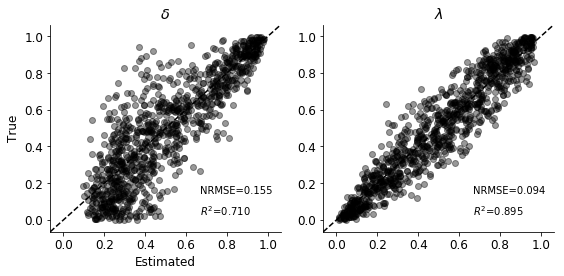

In [14]:
plot_true_est_scatter(model, x_test, theta_test, 
                      n_samples_posterior, 
                      param_names_l, figsize=(8, 4), font_size=12, filename='wcst', )

### Full posteriors
Example posteriors on validation data

In [28]:
theta_samples = model.sample(x_test, n_samples_posterior) 

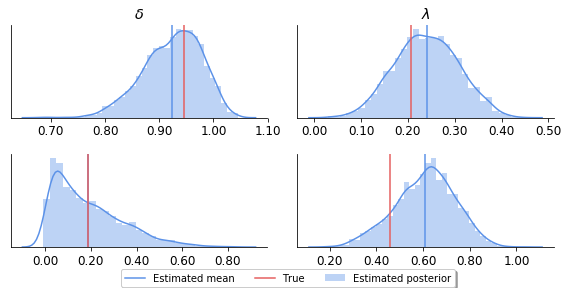

In [242]:
theta_samples_d = tf.stack( (theta_samples[:, 20, :], theta_samples[:, 0, :]), axis=1)
theta_test_d = tf.stack( (theta_test[20, :], theta_test[0, :]), axis=0)


plot_true_est_posterior_samples(theta_samples_d, 
                                theta_test_d, 
                                param_names_l, 
                                figsize=(8, 4), filename='wcst')

### IT measures

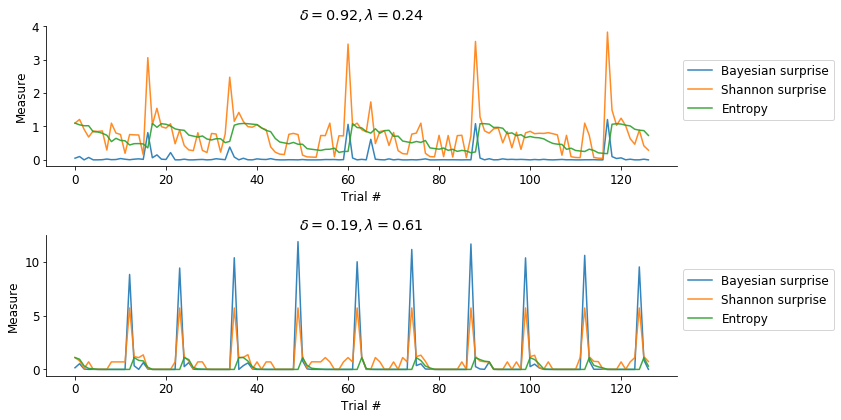

In [342]:
f, axarr = plt.subplots(2, 1, figsize=(12, 6))

# Bad example
which = 20
x_test_1 = np.concatenate((x_test[0][which].numpy(), 
                           x_test[1][which].numpy().argmax(axis=-1)[:, np.newaxis]), axis=-1)
m_test_1 = np.transpose(np.stack((x_test[2][which].numpy().argmax(axis=-1), 
                                  x_test[3][which].numpy().argmax(axis=-1),
                                  x_test[4][which].numpy().argmax(axis=-1))))
params_1 = theta_samples.numpy()[:, which, :].mean(axis=0)
it_1 = it_measures(x_test_1, m_test_1, params_1)


# Good example
which = 0
x_test_2 = np.concatenate((x_test[0][which].numpy(), 
                           x_test[1][which].numpy().argmax(axis=-1)[:, np.newaxis]), axis=-1)
m_test_2 = np.transpose(np.stack((x_test[2][which].numpy().argmax(axis=-1), 
                                  x_test[3][which].numpy().argmax(axis=-1),
                                  x_test[4][which].numpy().argmax(axis=-1))))
params_2 = theta_samples.numpy()[:, which, :].mean(axis=0)
it_2 = it_measures(x_test_2, m_test_2, params_2)



axarr[0].plot(it_1[:, 0], label='Bayesian surprise', lw=1.5, alpha=0.9)
axarr[0].plot(it_1[:, 1], label='Shannon surprise', lw=1.5, alpha=0.9)
axarr[0].plot(it_1[:, 2], label='Entropy', lw=1.5, alpha=0.9)
axarr[0].legend(loc="upper left", fontsize=12, bbox_to_anchor=(1.0, 0.8))

axarr[1].plot(it_2[:, 0], label='Bayesian surprise', lw=1.5, alpha=0.9)
axarr[1].plot(it_2[:, 1], label='Shannon surprise', lw=1.5, alpha=0.9)
axarr[1].plot(it_2[:, 2], label='Entropy', lw=1.5, alpha=0.9)
axarr[1].legend(loc="upper left", fontsize=12, bbox_to_anchor=(1.0, 0.8))


axarr[0].spines['right'].set_visible(False)
axarr[0].spines['top'].set_visible(False)
axarr[1].spines['right'].set_visible(False)
axarr[1].spines['top'].set_visible(False)
axarr[0].set_xlabel('Trial #')
axarr[1].set_xlabel('Trial #')
axarr[0].set_ylabel('Measure')
axarr[1].set_ylabel('Measure')
axarr[0].set_title(r'$\delta={0:.2f}, \lambda={1:.2f}$'.format(params_1[0], params_1[1]))
axarr[1].set_title(r'$\delta={0:.2f}, \lambda={1:.2f}$'.format(params_2[0], params_2[1]))

f.tight_layout()

# f.savefig("figures/it_measures.png", dpi=600, bbox_inches='tight')

### IT measures (simulated)

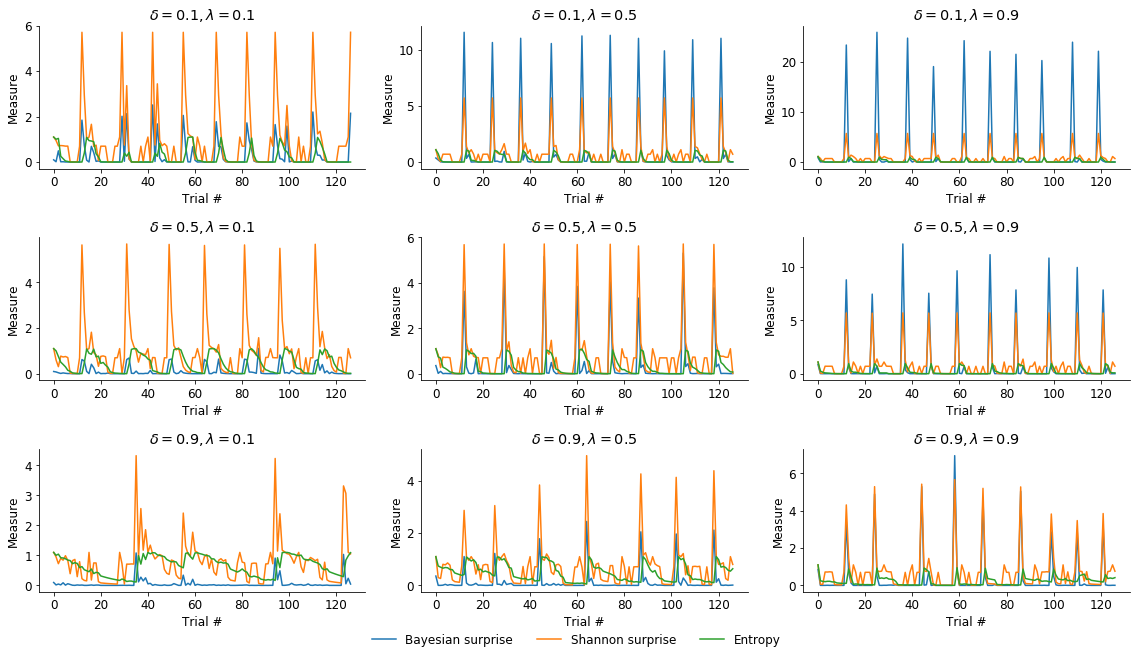

In [24]:
M = np.load('MatchingMat.npy').astype(np.int32)
delta = [0.1, 0.5, 0.9]
lambd = [0.1, 0.5, 0.9]

f, axarr = plt.subplots(3, 3, figsize=(16, 9))
for i, d in enumerate(delta):
    for j, l in enumerate(lambd):
        
        # Simulate 
        x = forward_model(np.array([d, l]), M=M)
        x_t = x[:, :2]
        m_t = x[:, 2:]
        
        # Generate information metrics
        it_m = it_measures(x_t, m_t, [d, l])
        
        # Plot it measures
        axarr[i,j].plot(it_m[:, 0], label='Bayesian surprise')
        axarr[i,j].plot(it_m[:, 1], label='Shannon surprise')
        axarr[i,j].plot(it_m[:, 2], label='Entropy')
        axarr[i,j].spines['right'].set_visible(False)
        axarr[i,j].spines['top'].set_visible(False)
        axarr[i,j].set_title(r'$\delta={0:.1f}, \lambda={1:.1f}$'.format(d, l))
        axarr[i,j].set_xlabel('Trial #')
        axarr[i,j].set_ylabel('Measure')
        
        if i == 0 and j == 0:
#             f.legend(loc="upper left", fontsize=12, bbox_to_anchor=(1.0, 0.5))
            f.legend(loc='lower center', bbox_to_anchor=(0.5, -0.02), ncol=3, fontsize=12, frameon=False, borderaxespad=1)

        
f.tight_layout()
f.savefig("figures/wcst_itmeasures_sim.png", dpi=600, bbox_inches='tight')

### PIT (Simulation-based calibration)
Note: posteriors are probabilistically well calibrated, if PIT histograms are approximately uniform

In [26]:
theta_samples = []
theta_sbc = []
for _ in range(20):
    theta, x_sbc = data_generator(250, n_obs=128)
    s = model.sample(x_sbc, n_samples=250, to_numpy=True)
    theta_samples.append(s)
    theta_sbc.append(theta)

Instructions for updating:
Colocations handled automatically by placer.


In [30]:
theta_samples = np.concatenate(theta_samples, axis=0)
theta_sbc = np.concatenate(theta_sbc, axis=0)

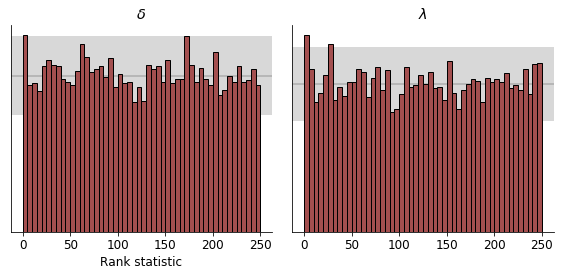

In [36]:
plot_sbc(theta_samples, theta_sbc, param_names_l, figsize=(8, 4), bins=50, filename='wcst')

### Compute all validation metrics (bootstrap)

In [119]:
# n_bootstrap = 100
# n_params = int(theta_test.shape[1])
# n_test = int(theta_test.shape[0])
    
# metrics = {
#     'cal_err': [],
#     'rmse': [],
#     'r2': [],
# }

# for bi in range(n_bootstrap):

#     # Get bootstrap samples
#     b_idx = np.random.choice(np.random.permutation(n_test), size=n_test, replace=True)
#     theta_test_b = tf.gather(theta_test, b_idx, axis=0).numpy()
#     theta_samples_b = tf.gather(theta_samples, b_idx, axis=1).numpy()

#     # Obtain metrics on bootstrap sample
#     cal_errs = calibration_error(theta_samples_b, theta_test_b)
#     nrmses = rmse(theta_samples_b, theta_test_b)
#     r2s = R2(theta_samples_b, theta_test_b)

#     # Add to dict
#     metrics['cal_err'].append(cal_errs)
#     metrics['rmse'].append(nrmses)
#     metrics['r2'].append(r2s)
    
#     print(bi)

# # Convert to arrays for convenience
# metrics = {k: np.array(v) for k, v in metrics.items()}

In [120]:
#pickle.dump(metrics, open('results/metrics_wcst.pkl', 'wb+'))
#metrics = pickle.load(open('results/metrics_wcst.pkl', 'rb+'))

In [125]:
print('Bootstrap metrics')
print('Calibration error delta : {0:.3f}+-{1:.3f}'.format(metrics['cal_err'].mean(axis=0)[0], 
                                                            metrics['cal_err'].std(axis=0)[0]))
print('Calibration error lambda : {0:.3f}+-{1:.3f}'.format(metrics['cal_err'].mean(axis=0)[1], 
                                                            metrics['cal_err'].std(axis=0)[1]))
print('-' * 10)

print('R2 delta : {0:.3f}+-{1:.3f}'.format(metrics['r2'].mean(axis=0)[0], 
                                             metrics['r2'].std(axis=0)[0]))
print('R2 lambda : {0:.3f}+-{1:.3f}'.format(metrics['r2'].mean(axis=0)[1], 
                                        metrics['r2'].std(axis=0)[1]))

print('-' * 10)


print('RMSE delta : {0:.3f}+-{1:.3f}'.format(metrics['rmse'].mean(axis=0)[0], 
                                             metrics['rmse'].std(axis=0)[0]))
print('RMSE lambda : {0:.3f}+-{1:.3f}'.format(metrics['rmse'].mean(axis=0)[1], 
                                        metrics['rmse'].std(axis=0)[1]))

Bootstrap metrics
Calibration error delta : 0.011+-0.005
Calibration error lambda : 0.014+-0.007
----------
R2 delta : 0.708+-0.015
R2 lambda : 0.895+-0.007
----------
RMSE delta : 0.155+-0.004
RMSE lambda : 0.094+-0.002


## Wall-clock time

In [16]:
%%time
model.sample(x_test, n_samples_posterior)

Wall time: 1.78 s


<tf.Tensor: id=8090, shape=(2000, 1000, 2), dtype=float32, numpy=
array([[[0.37377384, 0.17093101],
        [0.6345905 , 0.24408321],
        [0.6571831 , 0.05427301],
        ...,
        [0.12416211, 0.9291679 ],
        [0.7437933 , 0.8096068 ],
        [0.30299547, 0.0137624 ]],

       [[0.22470972, 0.19248253],
        [0.5713409 , 0.16349475],
        [0.7290703 , 0.08198669],
        ...,
        [0.8068934 , 0.9663399 ],
        [0.7980922 , 0.89310014],
        [0.38970932, 0.00940178]],

       [[0.40849617, 0.1818963 ],
        [0.50035745, 0.14567374],
        [0.76762915, 0.07820234],
        ...,
        [0.3134514 , 0.95807606],
        [0.58440864, 0.9457977 ],
        [0.35065717, 0.03809099]],

       ...,

       [[0.25792554, 0.17214811],
        [0.47488534, 0.02878627],
        [0.78003126, 0.09919185],
        ...,
        [0.13521981, 0.9235729 ],
        [0.728825  , 0.8480559 ],
        [0.30291444, 0.00997972]],

       [[0.17522998, 0.13409138],
        [0.

# Estimate real data

## Load and preprocess

In [26]:
M = np.load('MatchingMat.npy').astype(np.int32)
data = np.load('Data128.npy')
data = np.array(list(data.tolist().values()))
data = np.c_[data, np.array([M] * 10)]
data = [tf.keras.utils.to_categorical(data[:, :, i]) if i !=0 else data[:, :, 0:1] for i in range(data.shape[2])]
data = [tf.convert_to_tensor(d, dtype=tf.float32) for d in data]

In [27]:
n_samples_posterior = 5000
theta_hat = model.sample(data, n_samples=n_samples_posterior, to_numpy=True)

## Plot delta

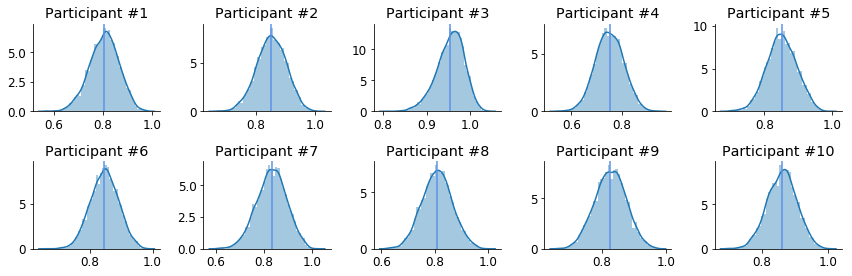

In [28]:
f, axarr = plt.subplots(2, 5, figsize=(12, 4))

for i, ax in enumerate(axarr.flat):
    sns.distplot(theta_hat[:, i, 0], ax=ax)
    ax.axvline(theta_hat.mean(axis=0)[i, 0], color='#5c92e8', label='Estimated mean')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_title('Participant #{}'.format(i+1))
    
f.tight_layout()

## Plot lambda

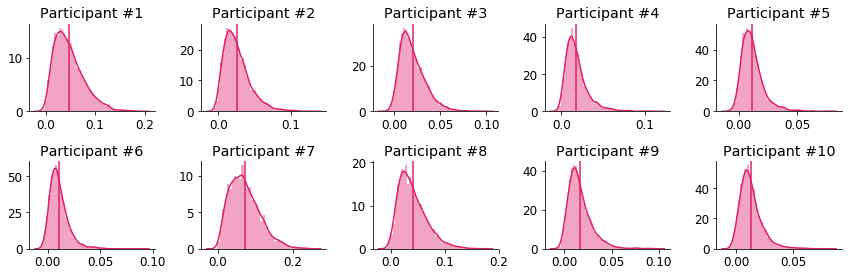

In [106]:
f, axarr = plt.subplots(2, 5, figsize=(12, 4))

for i, ax in enumerate(axarr.flat):
    sns.distplot(theta_hat[:, i, 1], ax=ax, color='#e01f69')
    ax.axvline(theta_hat.mean(axis=0)[i, 1], color='#e01f69', label='Estimated mean')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_title('Participant #{}'.format(i+1))
    
f.tight_layout()

## Joint plots all

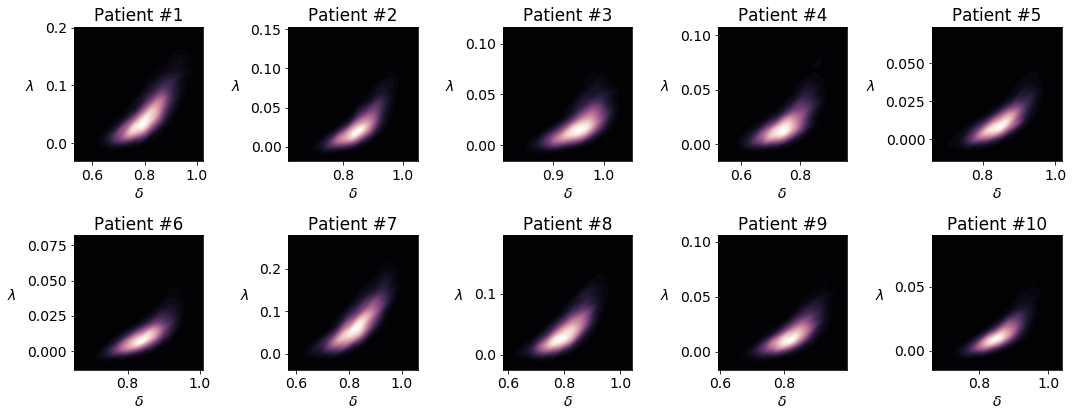

In [38]:
plt.rcParams['font.size'] = 14

f, axarr = plt.subplots(2, 5, figsize=(15, 6))
cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)

for i, ax in enumerate(axarr.flat):
    sns.kdeplot(theta_hat[:, i, 0], theta_hat[:, i, 1], ax=ax, cmap=cmap, n_levels=60, shade=True)
    ax.set_title('Patient #{}'.format(i+1))
    ax.set_xlabel(r'$\delta$')
    ax.set_ylabel(r'$\lambda$', rotation=0, labelpad=15)
    
f.tight_layout()

In [39]:
f.savefig("figures/wcst_estimates.png", dpi=600)

## Joint plots per participant

In [37]:
def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)

def plot_joint(samples, param_names, filename=None, figsize=(10, 6)):
    """
    Plots joint recovery plots on the full test sample.
    """
    

    all_params = pd.DataFrame(samples, columns=param_names)

    g = sns.PairGrid(all_params)
    g.map_lower(sns.scatterplot, alpha=0.9)
    g.map_lower(corrfunc)
#     g.map_lower(sns.kdeplot, alpha=0.9)
    g.map_diag(sns.distplot, hist=True, hist_kws=dict(edgecolor="k", linewidth=1, alpha=0.9))
    g.fig.set_figwidth(figsize[0])
    g.fig.set_figheight(figsize[1])
    
    g.axes[0, 1].set_visible(False)
    
    if filename is not None:
        g.savefig('figures/wcst_joint_{}.png'.format(filename), dpi=600)

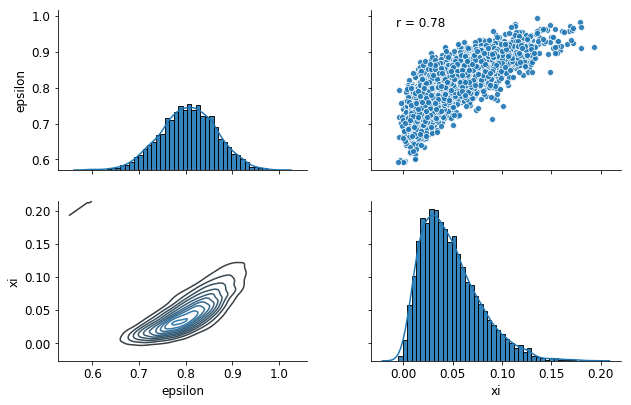

In [113]:
plot_joint(theta_hat[:, 0, :], param_names)

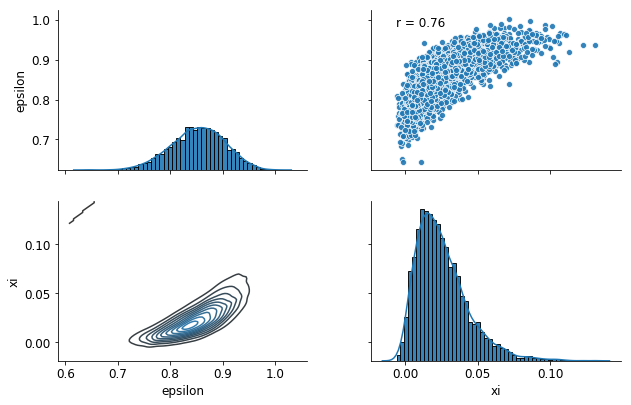

In [114]:
plot_joint(theta_hat[:, 1, :], param_names)

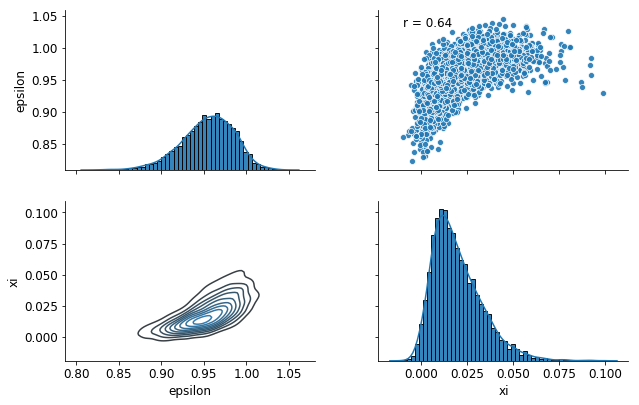

In [115]:
plot_joint(theta_hat[:, 2, :], param_names)

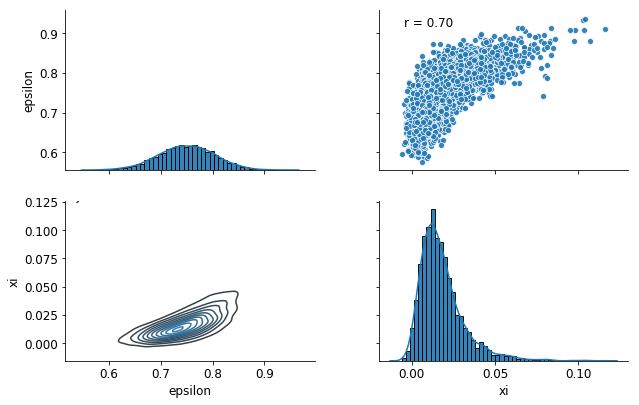

In [116]:
plot_joint(theta_hat[:, 3, :], param_names)

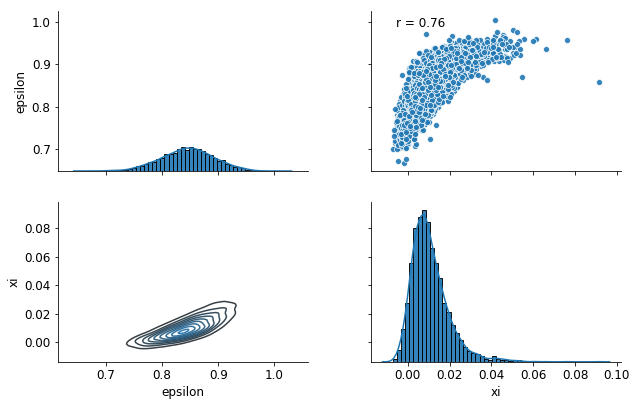

In [118]:
plot_joint(theta_hat[:, 5, :], param_names)

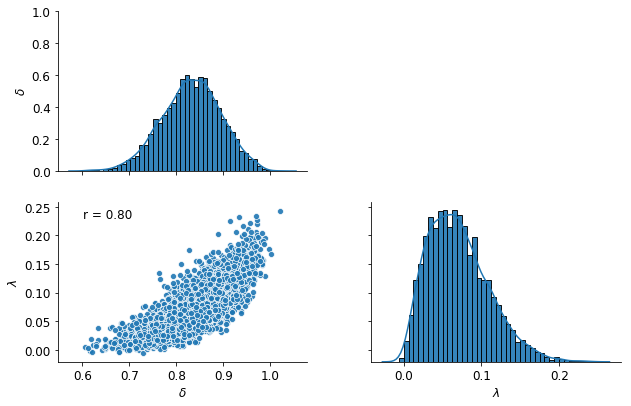

In [38]:
plot_joint(theta_hat[:, 6, :], param_names_l, 'subject7')

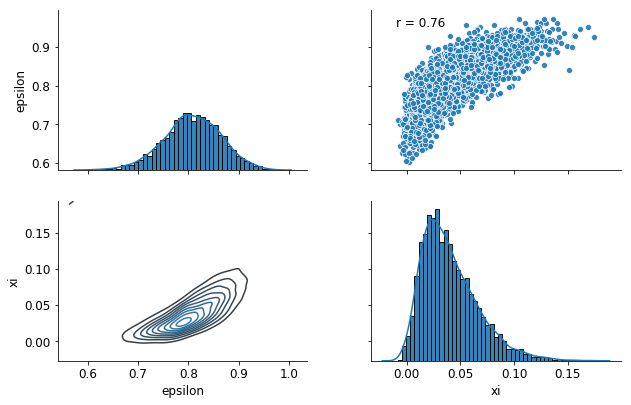

In [120]:
plot_joint(theta_hat[:, 7, :], param_names)

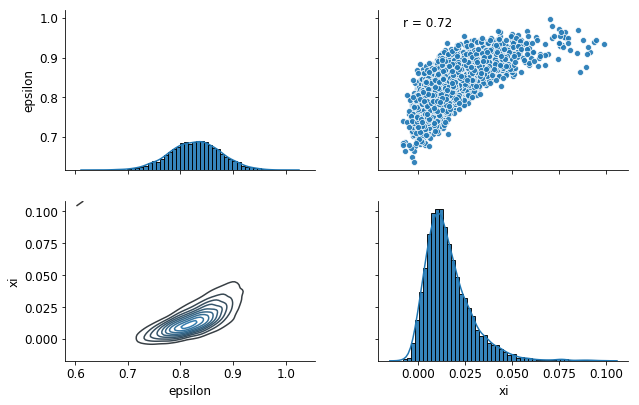

In [121]:
plot_joint(theta_hat[:, 8, :], param_names)

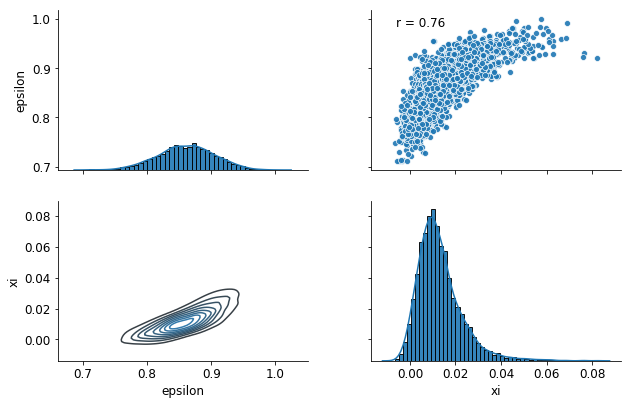

In [122]:
plot_joint(theta_hat[:, 9, :], param_names)